In [1]:
import pandas as pd
from matplotlib.pyplot import plot
from textblob import TextBlob

# config

In [2]:
cases_data = 'corona_lb_data.csv'
tweets_data = '..\\..\\Project_Final_Scripts\\tweets_data.csv'
save_to = 'tweets_sentiment.csv'


pd.set_option('display.max_rows', 255)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# read corona lb data

In [3]:
corona = pd.read_csv(cases_data, header=0)
# corona.head()

# months data

In [4]:
month_groups = corona.groupby('month')

months_data = {}

for month, month_data in month_groups:
    average_cases = int(month_data.new_cases.mean())
    average_death = int(month_data.new_deaths.mean())
    
    month_cases = int(month_data.new_cases.sum())
    month_deaths = int(month_data.new_deaths.sum())
    
    comulative_cases = int(month_data.total_cases.max())
    comulative_deaths = int(month_data.total_deaths.max())
    
    months_data[month] = {
        'average_cases':average_cases,
        'average_deaths':average_death,
        'month_cases': month_cases,
        'month_deaths': month_deaths,
        'comulative_cases': comulative_cases,
        'comulative_deaths': comulative_deaths,
    }

# sentiment ratio

In [5]:
cases_day_count = deaths_day_count = 0
cases_diff_sum = deaths_diff_sum = 0

def calculate(row):
    global cases_day_count, deaths_day_count, cases_diff_sum, deaths_diff_sum

    # ----------------------------------------------------------------------

    # method 1 - month average, by overall month data
    avg_cases1 = months_data[row.month]['average_cases']
    avg_deaths1 = months_data[row.month]['average_deaths']
    
    cases_ratio1 = row.new_cases / avg_cases1 if avg_cases1 else 0
    deaths_ratio1 = row.new_deaths / avg_deaths1 if avg_deaths1 else 0

    sentiment_ratio1 = (cases_ratio1 + deaths_ratio1) / 2
    
    # ----------------------------------------------------------------------

    # method 2 - cumulative average, by cumulative cases days data
    avg_cases2 = (row.total_cases / cases_day_count) if cases_day_count else 0
    avg_deaths2 = (row.total_deaths / deaths_day_count) if deaths_day_count else 0
    
    if row.new_cases:
        cases_day_count += 1
       
    if row.new_deaths:
        deaths_day_count += 1

    cases_ratio2 = row.new_cases / avg_cases2 if avg_cases2 else 0
    deaths_ratio2 = row.new_deaths / avg_deaths2 if avg_deaths2 else 0

    sentiment_ratio2 = (cases_ratio2 + deaths_ratio2) / 2
    
    # ----------------------------------------------------------------------
    
    # method 3 - cumulative diff average, by cumulative cases days diff data
    cases_diff = row.prev_cases - row.new_cases
    deaths_diff = row.prev_deaths - row.new_deaths

    avg_cases3 = (cases_diff_sum / cases_day_count) if cases_day_count else 0
    avg_deaths3 = (deaths_diff_sum / deaths_day_count) if deaths_day_count else 0
    
    if row.new_cases:
        cases_day_count += 1
        cases_diff_sum += abs(row.prev_cases - row.new_cases)
        
    if row.new_deaths:
        deaths_day_count += 1
        deaths_diff_sum += abs(row.prev_deaths - row.new_deaths)

    cases_ratio3 = cases_diff / avg_cases3 if avg_cases3 else 0
    deaths_ratio3 = deaths_diff / avg_deaths3 if avg_deaths3 else 0

    sentiment_ratio3 = (cases_ratio3 + deaths_ratio3) / 2

    # ----------------------------------------------------------------------
        
    # method 4 - simple direct ratio
    cases_max, cases_min = (row.new_cases, -row.prev_cases) if row.prev_cases < row.new_cases else (row.prev_cases, row.new_cases)
    cases_ratio4 = cases_min / cases_max if cases_max else 0
    
    deaths_max, deaths_min = (row.new_deaths, -row.prev_deaths) if row.prev_deaths < row.new_deaths else (row.prev_deaths, row.new_deaths)
    deaths_ratio4 = deaths_min / deaths_max if deaths_max else 0

    sentiment_ratio4 = (cases_ratio4 + deaths_ratio4) / 2

    # ----------------------------------------------------------------------
        
    return pd.Series([sentiment_ratio1, sentiment_ratio2, sentiment_ratio3, sentiment_ratio4])

corona[['sentiment_ratio1', 'sentiment_ratio2', 'sentiment_ratio3', 'sentiment_ratio4']] = corona.apply(calculate, axis=1)

In [6]:
columns = [
    'month',
    'day',
    'prev_cases',
    'new_cases',
    'prev_deaths',
    'new_deaths',
    'sentiment_ratio1',
    'sentiment_ratio2',
    'sentiment_ratio3',
    'sentiment_ratio4',
]

In [7]:
# corona[columns]

In [8]:
corona[columns].describe()

,month,day,prev_cases,new_cases,prev_deaths,new_deaths,sentiment_ratio1,sentiment_ratio2,sentiment_ratio3,sentiment_ratio4
count,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000
mean,5.223214,15.245536,102.607143,105.669643,0.991071,1.022321,0.612473,3.092275,-0.318062,0.050794
std,2.131169,8.876708,178.794361,182.857900,1.809271,1.852024,0.565216,3.238570,3.315741,0.363711
min,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.133893,-0.850893
25%,3.000000,7.750000,4.750000,5.000000,0.000000,0.000000,0.183606,0.583297,-1.626393,-0.232714
50%,5.000000,15.000000,17.000000,17.000000,0.000000,0.000000,0.500000,1.714286,0.000000,0.000000
75%,7.000000,23.000000,85.250000,87.000000,1.000000,1.000000,0.900266,5.442234,1.177529,0.329762
max,9.000000,31.000000,689.000000,689.000000,12.000000,12.000000,2.968085,12.879310,8.351852,0.961623


# scale ratio into range [-1, 1] using MinMaxScaler()

In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def min_max_scale(df, column_name):
    _2d_array = np.array(corona[column_name]).reshape(-1, 1)
    scaler = MinMaxScaler((-1, 1))
    data = scaler.fit_transform(_2d_array)
    print('Max:', scaler.data_max_)
    print('Min:', scaler.data_min_)
    column_data = list(data.reshape(1, -1)[0])
    df[f'scaled_{column_name}'] = pd.Series(column_data)
    df[f'scaled_{column_name}'].describe()

In [10]:
min_max_scale(corona, 'sentiment_ratio1')

Max: [2.96808511]
Min: [0.]


In [11]:
min_max_scale(corona, 'sentiment_ratio2')

Max: [12.87931034]
Min: [0.]


In [12]:
min_max_scale(corona, 'sentiment_ratio3')

Max: [8.35185185]
Min: [-13.13389279]


In [13]:
min_max_scale(corona, 'sentiment_ratio4')

Max: [0.96162281]
Min: [-0.85089286]


# convert data to dict for easier access

In [14]:
sentiment_ratio_dict = {}
for index, row in corona.iterrows():
    month = f'0{int(row.month)}'
    day = str(int(row.day)) if row.day > 10 else f'0{int(row.day)}'
    
    key = (month, day)
    sentiment_ratio_dict[key] = {
        'prev_cases': int(row.prev_cases),
        'new_cases': int(row.new_cases),
        'total_cases': int(row.total_cases),
        'prev_deaths': int(row.prev_deaths),
        'new_deaths': int(row.new_deaths),
        'total_deaths': int(row.total_deaths),
        'sentiment_ratio1': row.scaled_sentiment_ratio1,
        'sentiment_ratio2': row.scaled_sentiment_ratio2,
        'sentiment_ratio3': row.scaled_sentiment_ratio3,
        'sentiment_ratio4': row.scaled_sentiment_ratio4,
    }

# load tweets

In [15]:
tweets = pd.read_csv(tweets_data, header=0)
# tweets.head()

# split by date

In [16]:
tweets[['year', 'month', 'day']] = tweets.date.str.split('-', expand=True)

# get sentiment

In [17]:
def get_sentiments(row):
    text_sentiment = TextBlob(row.translated_text).sentiment.polarity
    
    key = (row.month, row.day)
    
    details = sentiment_ratio_dict.get(key)
    
    if details:
        ratio_sentiment1 = details['sentiment_ratio1']
        ratio_sentiment2 = details['sentiment_ratio2']
        ratio_sentiment3 = details['sentiment_ratio3']
        ratio_sentiment4 = details['sentiment_ratio4']
        
    else:
        ratio_sentiment1 = 0
        ratio_sentiment2 = 0
        ratio_sentiment3 = 0
        ratio_sentiment4 = 0

    return pd.Series([text_sentiment, ratio_sentiment1, ratio_sentiment2, ratio_sentiment3, ratio_sentiment4])

In [18]:
tweets[[
    'people_sentiment', 
    'ratio_sentiment1', 
    'ratio_sentiment2', 
    'ratio_sentiment3', 
    'ratio_sentiment4'
]] = tweets.apply(get_sentiments, axis=1)

# tweets.to_csv('tweets_ratios.csv', index=False)

# days statistics

In [19]:
config = {
    'month': 'first',
    'day': 'first',
    'people_sentiment': 'mean',
    'ratio_sentiment1': 'mean',
    'ratio_sentiment2': 'mean',
    'ratio_sentiment3': 'mean',
    'ratio_sentiment4': 'mean',
}
days = tweets.groupby(['month', 'day']).agg(config).reset_index(drop=True)
# days

In [20]:
X = range(len(days))
people_sentiment = days.people_sentiment
overall_month_avg = days.ratio_sentiment1
cumulative_new_avg = days.ratio_sentiment2
cumulative_diff_avg = days.ratio_sentiment3
simple_prev_new_ratio = days.ratio_sentiment4
Zero = [0 for x in X]

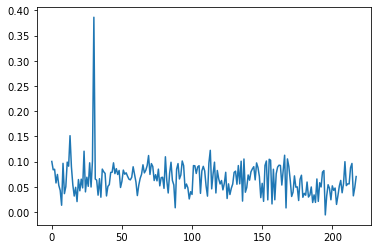

In [21]:
plot(X, people_sentiment)

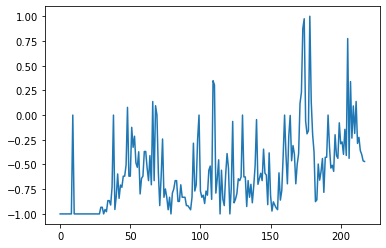

In [22]:
plot(X, overall_month_avg) 

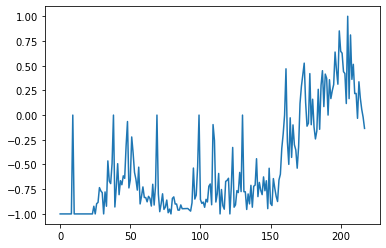

In [23]:
plot(X, cumulative_new_avg)

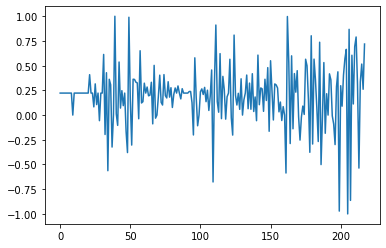

In [24]:
plot(X, cumulative_diff_avg)

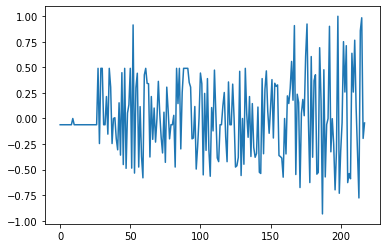

In [25]:
plot(X, simple_prev_new_ratio)

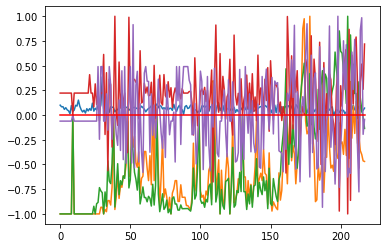

In [26]:
plot(X, people_sentiment, X, overall_month_avg, X, cumulative_new_avg, X, cumulative_diff_avg, X, simple_prev_new_ratio, X, Zero, 'r')

# months statistics

In [27]:
config = {
    'month': 'first',
    'people_sentiment': 'mean',
    'ratio_sentiment1': 'mean',
    'ratio_sentiment2': 'mean',
    'ratio_sentiment3': 'mean',
    'ratio_sentiment4': 'mean',
}
months = tweets.groupby('month').agg(config).reset_index(drop=True)
months

,month,people_sentiment,ratio_sentiment1,ratio_sentiment2,ratio_sentiment3,ratio_sentiment4
0,02,0.062686,-0.981225,-0.948726,0.212910,-0.030454
1,03,0.079293,-0.567745,-0.611270,0.203068,0.004046
2,04,0.071298,-0.573720,-0.843528,0.219538,0.071128
3,05,0.062952,-0.491631,-0.634008,0.172519,0.013940
4,06,0.063733,-0.643898,-0.740833,0.235403,-0.087560
5,07,0.059132,-0.289422,-0.182682,0.187890,0.076941
6,08,0.040589,-0.408542,0.324793,0.072434,-0.050912
7,09,0.067839,-0.393474,0.055281,0.315948,0.134749


In [28]:
X = months.month
people_sentiment = months.people_sentiment
overall_month_avg = months.ratio_sentiment1
cumulative_new_avg = months.ratio_sentiment2
cumulative_diff_avg = months.ratio_sentiment3
simple_prev_new_ratio = months.ratio_sentiment4
Zero = [0 for x in range(len(months.month))]

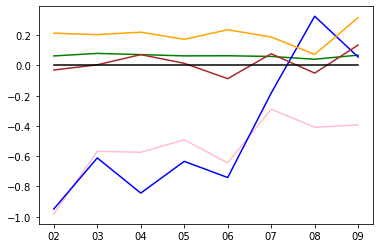

In [29]:
plot(X, people_sentiment, 'g', X, overall_month_avg, 'pink', X, cumulative_new_avg, 'b', X, cumulative_diff_avg, 'orange', X, simple_prev_new_ratio, 'brown', X, Zero, 'black')

# Explanation

1. `Green` (people_sentiment)
    - The people sentiment curve.
    - It visualize the change in people sentiment/view on corona over time.
    - Useful for checking the people care about corona. 
    - `y increase == people are more neutral or positve == they either don't care anymore or the situation is getting better`


2. `Pink` (ratio_sentiment1)
    - The situtation curve according to each month overall situation. 
    - Formula = new cases / month's avg (from the view of the whole month)
    - It visualize the new cases & deaths situation according to the whole month average.
    - Useful for checking each month overall cases & death situation. 
    - `y increase == cases & deaths ratio increases == not a good sign (compared to month data)`


3. `Blue` (ratio_sentiment2)
    - The situtation curve according to the cumulative cases days data average. 
    - Formula = new cases / cumualtive cases days average (from the view of previous cases data)
    - It visualize the new cases & deaths situation according to the cumulative average from the first time a case showed up.
    - Useful for checking the cumulative situation till a specific date.
    - `y increase == cases & deaths ratio increases == not a good sign (compared to all previous data)`
    

4. `Orange` (ratio_sentiment3)
    - The situtation curve according to the cumulative cases days data diff average. 
    - Formula = (prev cases - new cases) / cumualtive cases days diff average (from the view of previous cases data diff data)
    - It visualize the change in cases & deaths cases over time.
    - Useful for checking the change in cases.
    - `y increase or decreasse == big previous & new cases/deaths diff == hotspot`


5. `Brown` (ratio_sentiment4)
    - The situtation curve according to simple ratio (Formula = a / b) relation.
    - It visualize the simple relation btw new and previous cases 7 deaths.
    - `y increase == new cases/deaths is less than previous cases/deaths == positive situation`


6. `Black`
    - The Zero (Neutral) Line, where y = 0

# Observations

1. `people_sentiment` ==> use `months` data


2. `ratio_sentiment1` ==> use `months` data


3. `ratio_sentiment2` ==> use `months` data


4. `ratio_sentiment3` ==> use `days` data


5. `ratio_sentiment4` ==> use `days` data